In [12]:
import numpy as np
import constants
import quaternion as qt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
def RK4(f, x0x1, y0, step, step_process = lambda y: y):
    # f MUST takes x and y as arguments: f(x, y)
    # It solves equation y' = f(x, y), y(x0) = y0 (everything is a vector)
    # from x0x1[0] to x0x1[1] on the grid with step step
    # step_process - FUNCTION that is called after every step to somehow process results (normalization and so on)
    # step_process - must take y argument (for single time step) as input and return the same shape numpy.ndarray
    # by default it doesn't do anything
    # returns array of (x, y) pairs
    x0 = x0x1[0]
    x1 = x0x1[1]
    current_x = np.array(x0, dtype = np.float64)
    current_y = np.array(y0, dtype = np.float64)
    result = [[x0, *y0]]
    h = step
    h2 = h/2
    h6 = h/6
    stop = x1 - h
    while current_x < stop:
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        result.append(np.array([current_x.copy(), *current_y.copy()]))

    if current_x < x1 - constants.max_to_zero:
        h = x1 - current_x
        h2 = h/2
        h6 = h/6
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        result.append(np.array([current_x.copy(), *current_y.copy()]))       
    
    return np.array(result)

def Euler(t, w, A, params, M = lambda t, w, A: np.array([0, 0, 0])):
    # return w' accroding to Euler's dinamic equation
    # A - orientation QUATERNION
    # M(t, w, A) - function of external moment in bounded axes
    return params.Jinv @ (M(t, w, A, params) - np.cross(w, params.J @ w))

def Torque(t, w, A, params):
    e1 = qt.as_float_array(A * np.quaternion(1, 0, 0) * A.inverse())[1:]
    e2 = qt.as_float_array(A * np.quaternion(0, 1, 0) * A.inverse())[1:]
    e3 = qt.as_float_array(A * np.quaternion(0, 0, 1) * A.inverse())[1:]
    cm = qt.as_float_array(A * np.quaternion(*params.initial_cm_position) * A.inverse())[1:]
    Mi = np.cross([0, 0, 1], cm) * params.mass * params.g * params.distance_to_cm
    Me = np.array([np.dot(Mi, e1), np.dot(Mi, e2), np.dot(Mi, e3)])
    return Me

def QuatDot(Ai, we):
    return np.quaternion(*Ai) * np.quaternion(*we) * 0.5

def f1(t, x, params):
    # x[:3] - we, x[3:] - Ai
    we = x[:3]
    Ai = x[3:]
    res = np.empty(7)
    res[:3] = Euler(t, we, np.quaternion(*Ai), params, Torque)
    res[3:] = qt.as_float_array(QuatDot(Ai, we))
    return res

def normalization(x):
    we = x[:3]
    Ai = x[3:]
    Ai /= np.linalg.norm(Ai) # normalization
    res = np.empty(7)
    res[:3] = we
    res[3:] = Ai
    return res




class parameters:
    pass

J = np.zeros((3, 3))
J[0,0] = 1
J[1, 1] = 1
J[2, 2] = 2
Jinv = np.linalg.inv(J)

params = parameters()
params.initial_cm_position = np.array([0, 0, 1])
params.distance_to_cm = 0.1
params.mass = 0.5
params.J = J
params.Jinv = Jinv
params.g = 9.81

In [14]:
# Интегрирование тут
t0 = 0.
t1 = 10.
step = 0.001
we0 = np.array([1, 1, 1])
A0 = np.quaternion(1, 0, 0, 0)
x0 = np.hstack((we0, qt.as_float_array(A0)))

result = RK4(lambda t, x: f1(t, x, params), (t0, t1), x0, step, normalization)

In [67]:
time_points = result[:, 0]
we = np.array([np.quaternion(*i) for i in result[:, 1:4]])
A = qt.as_quat_array(result[:, 4:])
wi = np.array([(j * i * j.inverse()) for i, j in zip(we, A)])
e3 = np.quaternion(0, 0, 1)
e3 = np.array([qt.as_float_array((j * e3 * j.inverse()))[1:] for j in A])
rotations = []
for i in A:
    i = qt.as_float_array(i)
    ang = 2 * np.arccos(i[0])
    n = np.linalg.norm(i[1:])
    e = i[1:]/np.linalg.norm(i[1:]) if n!=0 else np.array([0, 0, 0])
    rotations.append(np.array([ang, *e]))
rotations = np.array(rotations)

In [68]:
# Посчитаю моменты
Ke = np.array([J @ qt.as_float_array(i)[1:] for i in we])
Ki = np.array([qt.as_float_array(j * np.quaternion(*i) * j.inverse())[1:] for i, j in zip(Ke, A)])

Проверим интегралы движения:  
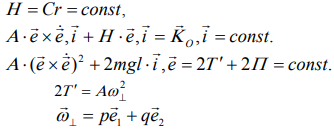

Максимальное изменение кин. момента на OZ (ИСО): 4.707345624410664e-14
Максимальное изменение кин. момента на e3 (связанные оси): 0.0


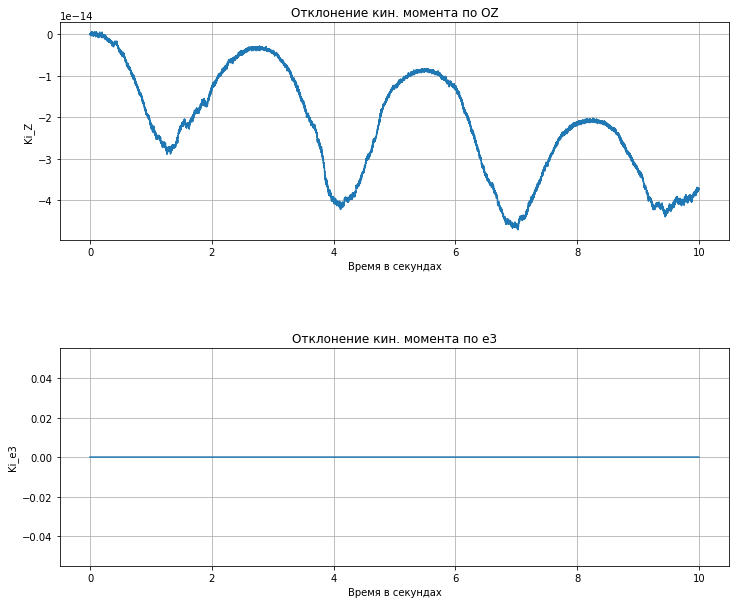

In [69]:
# Первый и второй интегралы (проекции кин. моменты на e3 и на OZ)
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.subplots_adjust(hspace = 0.5)

axes[0].plot(time_points, Ki[:, 2] - Ki[0, 2])
axes[0].set_title("Отклонение кин. момента по OZ")
axes[0].set_xlabel("Время в секундах")
axes[0].set_ylabel("Ki_Z")
axes[0].grid(True)

axes[1].plot(time_points, Ke[:, 2] - Ke[0, 2])
axes[1].set_title("Отклонение кин. момента по e3")
axes[1].set_xlabel("Время в секундах")
axes[1].set_ylabel("Ki_e3")
axes[1].grid(True)

print("Максимальное изменение кин. момента на OZ (ИСО):", np.max(np.abs(Ki[:, 2] - Ki[0, 2])))
print("Максимальное изменение кин. момента на e3 (связанные оси):", np.max(np.abs(Ke[:, 2] - Ke[0, 2])))

Максимальное изменение Integral3: 5.417888360170764e-14


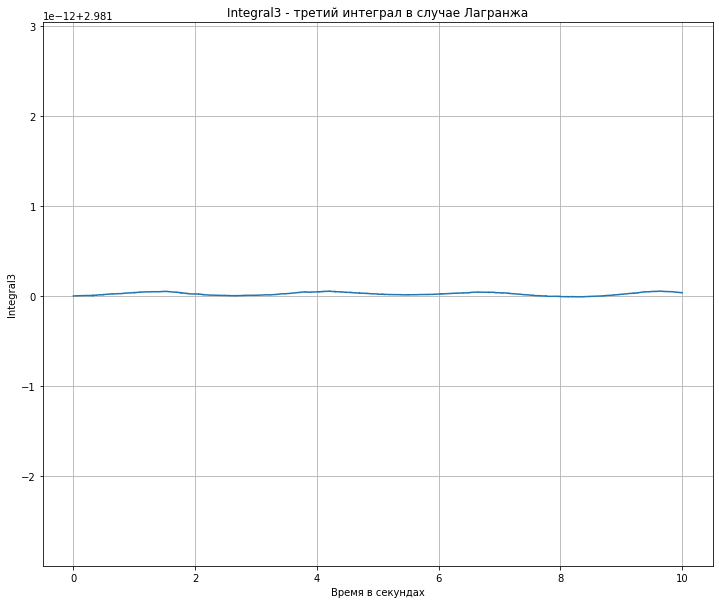

In [71]:
# Третий интеграл
wwe = np.array([qt.as_float_array(i)[1:] for i in we])
weq2 = wwe[:, 0]**2 + wwe[:, 1]**2
T2 = J[0, 0] * weq2
P2 = 2 * params.mass * params.distance_to_cm * e3[:, 2] * params.g
Integral3 = T2 + P2

fig, axes = plt.subplots(1)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.subplots_adjust(hspace = 0.5)

axes.plot(time_points, Integral3)
axes.set_title("Integral3 - третий интеграл в случае Лагранжа")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("Integral3")
axes.grid(True)

print("Максимальное изменение Integral3:", np.max(np.abs(Integral3 - Integral3[0])))

Вывод: интегралы движения хорошо сохраняются

In [146]:
# Подбираем параметры
t0 = 0.
t1 = 200.
step = 0.001
we0 = np.array([0, 0, 20])
A0 = np.quaternion(np.cos(np.pi/4), np.sin(np.pi/4), 0, 0)
x0 = np.hstack((we0, qt.as_float_array(A0)))

result = RK4(lambda t, x: f1(t, x, params), (t0, t1), x0, step, normalization)

In [147]:
time_points = result[:, 0]
we = np.array([np.quaternion(*i) for i in result[:, 1:4]])
A = qt.as_quat_array(result[:, 4:])
wi = np.array([(j * i * j.inverse()) for i, j in zip(we, A)])
e3 = np.quaternion(0, 0, 1)
e3 = np.array([qt.as_float_array((j * e3 * j.inverse()))[1:] for j in A])

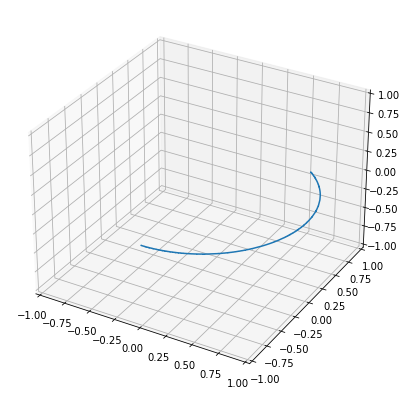

In [148]:
# Посмотрим как движется e3
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
ax.set_zlim((-1, 1))
ax.plot(*e3.T)
pass

Тело совершает регулярную прецессию :)